# Winter Arctic sea ice state variability (updates through to April 2023)

**Summary**: In this notebook, we provide the second update to the original winter Arctic sea ice thickness notebooks with an additional winter (2022-2023) of data collection using rel006 data. At the end of the notebook we include a few additional plots to try and better highlight the variable sea ice thickness data.

**Version history**: Version 1 (08/21/2023)



WHAT TO INCLUDE

 - JUST SHOW THE TIME SERIES OF FREEBOARD AND THICKNESS AND HOW THEY COMPARE FIRST OF ALL?!
 - SHOW NEW VARIABLES
  - SHOW NEW UNC CALCULATIONS!

 

# Import notebook dependencies

In [13]:
# For working with gridded climate data 
import xarray as xr 
# Helper function for reading the data from the bucket
from utils.read_data_utils import read_IS2SITMOGR4, read_ISSITGR4
from utils.plotting_utils import static_winter_comparison_lineplot, staticArcticMaps, staticArcticMaps_overlayDrifts, interactiveArcticMaps, compute_gridcell_winter_means, interactive_winter_comparison_lineplot # Plotting utils 
import numpy as np
import holoviews as hv
# Plotting dependencies
#%config InlineBackend.figure_format = 'retina'
import matplotlib as mpl
# Sets figure size in the notebook
mpl.rcParams['figure.dpi'] = 150 

# Remove warnings to improve display
import warnings 
warnings.filterwarnings('ignore') 

In [14]:
# Read in the raw monthly gridded winter Arctic sea ice data from local storage (includes prelim data in this case)
IS2SITMOGR4_v2 = read_IS2SITMOGR4(data_type='netcdf', local_data_path='./data/IS2SITMOGR4/', version='V2') 

./data/IS2SITMOGR4/V2/*.nc
Load in netcdf files to xarray dataset


In [15]:
# Read in the raw monthly gridded winter Arctic sea ice data from local storage (includes prelim data in this case)
IS2SITMOGR4_v3 = read_IS2SITMOGR4(data_type='netcdf', local_data_path='./data/IS2SITMOGR4/', version='V3') 
IS2SITMOGR4_v3

./data/IS2SITMOGR4/V3/*.nc
Load in netcdf files to xarray dataset


<xarray.Dataset>
Dimensions:                         (x: 304, y: 448, time: 38)
Coordinates:
  * x                               (x) float32 -3.838e+06 ... 3.738e+06
  * y                               (y) float32 5.838e+06 ... -5.338e+06
  * time                            (time) datetime64[ns] 2018-11-01 ... 2023...
    longitude                       (y, x) float32 168.3 168.1 ... -10.18 -9.999
    latitude                        (y, x) float32 31.1 31.2 ... 34.58 34.47
Data variables: (12/27)
    crs                             (time) float64 -2.147e+09 ... -2.147e+09
    ice_thickness                   (time, y, x) float32 nan nan nan ... nan nan
    ice_thickness_unc               (time, y, x) float32 nan nan nan ... nan nan
    num_segments                    (time, y, x) float32 nan nan nan ... nan nan
    mean_day_of_month               (time, y, x) float32 nan nan nan ... nan nan
    snow_depth                      (time, y, x) float32 nan nan nan ... nan nan
    ...                              ...
    ice_thickness_unc_freeboard     (time, y, x) float32 nan nan nan ... nan nan
    ice_thickness_unc_ice_density   (time, y, x) float32 nan nan nan ... nan nan
    ice_thickness_unc_snow_density  (time, y, x) float32 nan nan nan ... nan nan
    ice_thickness_unc_snow_depth    (time, y, x) float32 nan nan nan ... nan nan
    sea_ice_conc                    (time, y, x) float32 nan nan nan ... nan nan
    region_mask                     (time, y, x) float32 0.0 0.0 0.0 ... 0.0 0.0
Attributes:
    contact:      Alek Petty (akpetty@umd.edu)
    description:  IS2SITMOGR4, version 003. Gridded Jan 2020 winter Arctic se...
    reference:    Official NSIDC data doi: 10.5067/CV6JEXEE31HF. Derived data...
    history:      Created 09/11/23

In [16]:

# Years over which to perform analysis
years = [2018,2019,2020, 2021, 2022]

# Winter mean Arctic maps (static)
Compute and map (static) mean winter sea ice conditions across the years of analysis chosen

In [17]:
#freeboard_winter_means.time.values

In [18]:

#staticArcticMaps(100*thickness_unc_winter_means/thickness_winter_means, dates=thickness_unc_winter_means.time.values,title="", set_cbarlabel = "Sea ice thickness uncertainty (% total)", col_wrap=3, cmap="viridis", vmin=0, vmax=200, out_str='thickness_unc_winter_2018_2023')


# Monthly mean timeseries (overlaid)
Next we'll compute monthly means by averaging over all gridcells within a given region. We'll use this to generate a lineplot to compare across the three winter seasons for each variable.

In [19]:
# Here is where we might also want to set a region mask, e.g. to avoid including some of the more uncertain data in the peripheral seas
innerArctic = [1,2,3,4,5,6]
IS2SITMOGR4_v2 = IS2SITMOGR4_v2.where(IS2SITMOGR4_v2.region_mask.isin(innerArctic))
IS2SITMOGR4_v3 = IS2SITMOGR4_v3.where(IS2SITMOGR4_v3.region_mask.isin(innerArctic))

# Uncomment out to set an additional ice type mask too and change the save_label accordingly (0 = FYI, 1 = MYI)
#IS2SITMOGR4_all_innerArctic = IS2SITMOGR4_all_innerArctic.where(IS2SITMOGR4_all_innerArctic.ice_type==1)

save_label='Inner_Arctic'


# Monthly mean timeseries (adjacent years)
Plot the data in time to show seasonal changes. 

Utilize holoviews and the BGEP/CS-2/PIOMAS plotting functions from previous notebooks

In [20]:
# Drop Sep and October as coverage issues means they are hard to interpret
IS2SITMOGR4_v2 = IS2SITMOGR4_v2.where(((IS2SITMOGR4_v2['time.month'] > 10)|(IS2SITMOGR4_v2['time.month'] < 5)), drop=True)
IS2SITMOGR4_v3 = IS2SITMOGR4_v3.where(((IS2SITMOGR4_v3['time.month'] > 10)|(IS2SITMOGR4_v3['time.month'] < 5)), drop=True)

# Take monthly means
# Include missing months as NaNs so they dont plot
IS2SITMOGR4_v2_means = IS2SITMOGR4_v2.mean(dim=("x","y"), skipna=True, keep_attrs=True).resample(skipna=True, time='1M').asfreq()
IS2SITMOGR4_v3_means = IS2SITMOGR4_v3.mean(dim=("x","y"), skipna=True, keep_attrs=True).resample(skipna=True, time='1M').asfreq()


In [21]:

# Holoviews requires us to generate individual line plots then combine later
freeboard_plot_2 = IS2SITMOGR4_v2_means.freeboard_int.hvplot.line(grid=True, color='k', frame_width=700, frame_height=250) * IS2SITMOGR4_v2_means.freeboard_int.hvplot.scatter(marker='x', color='k', size=40).opts(ylabel="Total freeboard (m)") # Overlay scatter plot to add markers
freeboard_plot_3 = IS2SITMOGR4_v3_means.freeboard_int.hvplot.line(grid=True, color='b', frame_width=700, frame_height=250) * IS2SITMOGR4_v3_means.freeboard_int.hvplot.scatter(marker='x', color='b', size=40).opts({'Scatter': {'yticks': [ (0.2, '0.20'), (0.25, '0.25'), (0.3, '0.30'), (0.35, '0.35'), (0.4, '0.40')]}}) # Overlay scatter plot to add markers

snow_depth_plot_2 = IS2SITMOGR4_v2_means.snow_depth_int.hvplot.line(grid=True, color='k', frame_width=700, frame_height=250) * IS2SITMOGR4_v2_means.snow_depth_int.hvplot.scatter(marker='x', color='k', size=40,).opts(ylabel="Snow depth (m)") # Overlay scatter plot to add markers
snow_depth_plot_3 = IS2SITMOGR4_v3_means.snow_depth_int.hvplot.line(grid=True, color='b', frame_width=700, frame_height=250) * IS2SITMOGR4_v3_means.snow_depth_int.hvplot.scatter(marker='x', color='b', size=40).opts({'Scatter': {'yticks': [ (0.12, '0.12'), (0.15, '0.15'), (0.18, '0.18'), (0.21, '0.21'), (0.24, '0.24'), (0.27, '0.27')]}}) # Overlay scatter plot to add markers


thickness_plot_2 = IS2SITMOGR4_v2_means.ice_thickness_int.hvplot.line(grid=True, color='k', frame_width=700, frame_height=250) * IS2SITMOGR4_v2_means.ice_thickness_int.hvplot.scatter(marker='x', color='k', size=40, label='002').opts(ylabel="Sea ice thickness (m)", legend_position=("bottom_left")) # Overlay scatter plot to add markers
thickness_plot_3 = IS2SITMOGR4_v3_means.ice_thickness_int.hvplot.line(grid=True, color='b', frame_width=700, frame_height=250) * IS2SITMOGR4_v3_means.ice_thickness_int.hvplot.scatter(marker='x', color='b', size=40, label='003').opts({'Scatter': {'yticks': [ (1.0, '1.00'), (1.25, '1.25'), (1.5, '1.50'), (1.75, '1.75'), (2.0, '2.00')]}}) # Overlay scatter plot to add markers

plots_all = ((freeboard_plot_2*freeboard_plot_3) + (snow_depth_plot_2*snow_depth_plot_3) + (thickness_plot_2 * thickness_plot_3)).cols(1)

plots_all.opts(hv.opts.Layout(shared_axes=True)) 

# Frame width has an alignment issue
frame_height=160
frame_width=800
plots_all.opts({'Scatter': {'frame_height': frame_height}})
plots_all.opts({'Curve': {'frame_height': frame_height}})

plots_all.opts(title=" IS2SITMOGR4 002/003 comparison (2018-2023)", fontsize=10)
display(plots_all)
#hv.renderer('bokeh').save(plots_all, './figs/icesat-2_thickness_int_2018-2023_v2_v3.png', fmt='pdf')

from bokeh.io import export_svgs
#plots_all.output_backend = "svg"
#export_svgs(plots_all, filename = "plot.svg")


#hv.output(backend='matplotlib', fig='svg')
hv.save(plots_all, './figs/icesat-2_thickness_int_2018-2023_v2_v3.png', fmt='png')
#hv.save(plots_all, './figs/icesat-2_thickness_int_2018-2023_v2_v3', fmt='auto', dpi=600)

:Layout
   .Overlay.I   :Overlay
      .Curve.I    :Curve   [time]   (freeboard_int)
      .Scatter.I  :Scatter   [time]   (freeboard_int)
      .Curve.II   :Curve   [time]   (freeboard_int)
      .Scatter.II :Scatter   [time]   (freeboard_int)
   .Overlay.II  :Overlay
      .Curve.I    :Curve   [time]   (snow_depth_int)
      .Scatter.I  :Scatter   [time]   (snow_depth_int)
      .Curve.II   :Curve   [time]   (snow_depth_int)
      .Scatter.II :Scatter   [time]   (snow_depth_int)
   .Overlay.III :Overlay
      .Curve.I       :Curve   [time]   (ice_thickness_int)
      .Scatter.A_002 :Scatter   [time]   (ice_thickness_int)
      .Curve.II      :Curve   [time]   (ice_thickness_int)
      .Scatter.A_003 :Scatter   [time]   (ice_thickness_int)

In [29]:
IS2SITMOGR4_v3

<xarray.Dataset>
Dimensions:                         (time: 30, y: 448, x: 304)
Coordinates:
  * x                               (x) float32 -3.838e+06 ... 3.738e+06
  * y                               (y) float32 5.838e+06 ... -5.338e+06
  * time                            (time) datetime64[ns] 2018-11-01 ... 2023...
    longitude                       (y, x) float32 168.3 168.1 ... -10.18 -9.999
    latitude                        (y, x) float32 31.1 31.2 ... 34.58 34.47
Data variables: (12/27)
    crs                             (time, y, x) float64 nan nan nan ... nan nan
    ice_thickness                   (time, y, x) float32 nan nan nan ... nan nan
    ice_thickness_unc               (time, y, x) float32 nan nan nan ... nan nan
    num_segments                    (time, y, x) float32 nan nan nan ... nan nan
    mean_day_of_month               (time, y, x) float32 nan nan nan ... nan nan
    snow_depth                      (time, y, x) float32 nan nan nan ... nan nan
    ...                              ...
    ice_thickness_unc_freeboard     (time, y, x) float32 nan nan nan ... nan nan
    ice_thickness_unc_ice_density   (time, y, x) float32 nan nan nan ... nan nan
    ice_thickness_unc_snow_density  (time, y, x) float32 nan nan nan ... nan nan
    ice_thickness_unc_snow_depth    (time, y, x) float32 nan nan nan ... nan nan
    sea_ice_conc                    (time, y, x) float32 nan nan nan ... nan nan
    region_mask                     (time, y, x) float32 nan nan nan ... nan nan
Attributes:
    contact:      Alek Petty (akpetty@umd.edu)
    description:  IS2SITMOGR4, version 003. Gridded Jan 2020 winter Arctic se...
    reference:    Official NSIDC data doi: 10.5067/CV6JEXEE31HF. Derived data...
    history:      Created 09/11/23

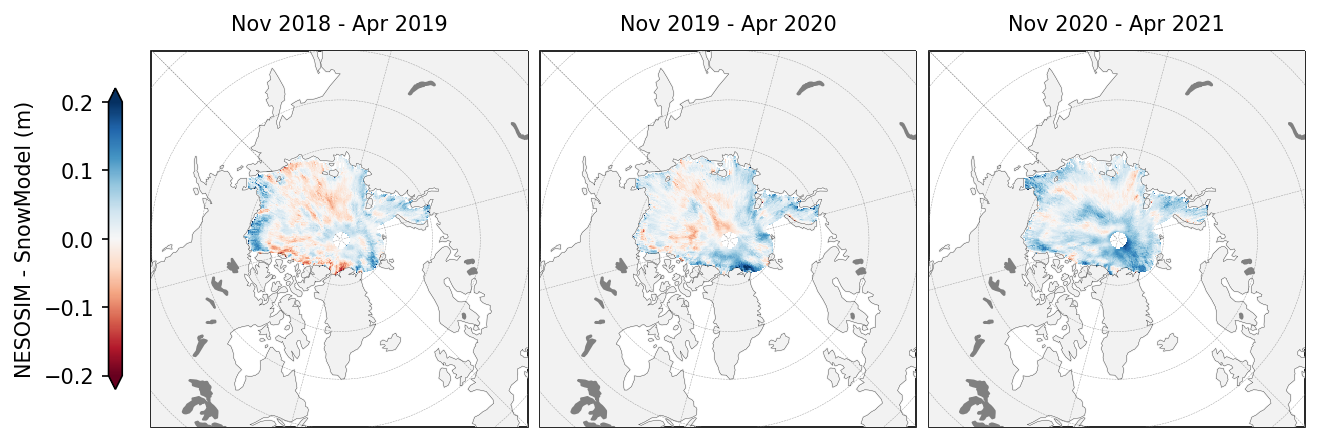

In [35]:
#SHOW DIFFERENCES BY THE PRODUCT?

snow_depth_winter_means_N = compute_gridcell_winter_means(IS2SITMOGR4_v3.snow_depth, years=[2018,2019,2020])
snow_depth_winter_means_SM = compute_gridcell_winter_means(IS2SITMOGR4_v3.snow_depth_sm,  years=[2018,2019,2020])

staticArcticMaps(snow_depth_winter_means_N-snow_depth_winter_means_SM, dates=snow_depth_winter_means.time.values,set_cbarlabel = "NESOSIM - SnowModel (m)", cmap="RdBu", col_wrap=3, vmin=-0.2, vmax=0.2, out_str='snowdepth_winter_2018_2023_v2_v3')


In [ ]:
MAYBE SHOW SOME MAP DIFFERENCES??